In [1]:
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import heapq
import math

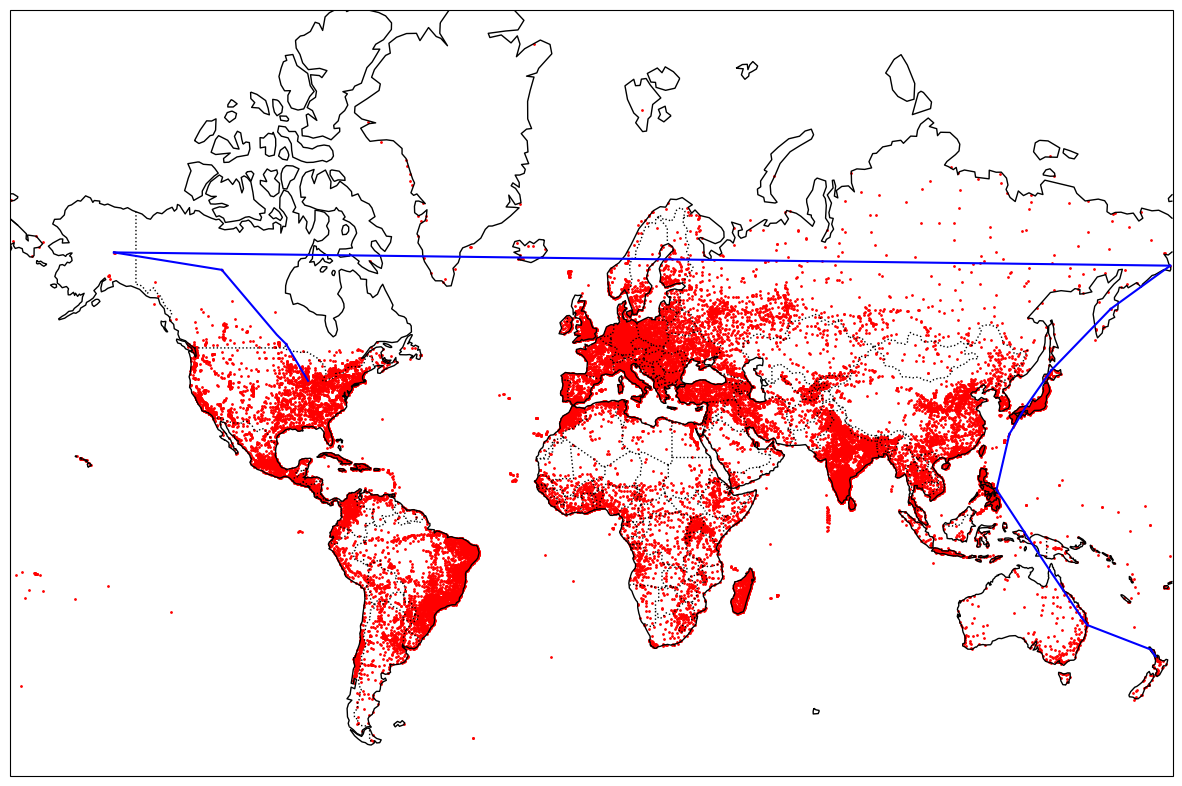

In [2]:
df = pd.read_csv('Data\Cities\worldcities.csv')

#Distance finder function
def haversine(coord1, coord2):
    R = 6371
    dlat = math.radians(coord2[0] - coord1[0])
    dlon = math.radians(coord2[1] - coord1[1])
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(coord1[0])) * math.cos(math.radians(coord2[0])) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = R * c
    return distance

#Pathfinding function
def a_star_search(start_city, end_city, df, distance_threshold=1000):
    start_coords = tuple(df[df['city_ascii'] == start_city][['lat', 'lng']].values[0])
    end_coords = tuple(df[df['city_ascii'] == end_city][['lat', 'lng']].values[0])

    open_set = [(0, start_coords)]
    came_from = {}
    g_score = {tuple(coord): float('inf') for coord in df[['lat', 'lng']].values}
    g_score[start_coords] = 0
    f_score = {tuple(coord): float('inf') for coord in df[['lat', 'lng']].values}
    f_score[start_coords] = haversine(start_coords, end_coords)

    while open_set:
        _, current = heapq.heappop(open_set)

        if current == end_coords:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(current)
            return path[::-1]

        for neighbor in df[['lat', 'lng']].values:
            neighbor = tuple(neighbor)
            dist = haversine(current, neighbor)
            if dist > distance_threshold:
                continue

            tentative_g_score = g_score[current] + dist
            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + haversine(neighbor, end_coords)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return []


#Plot size
plt.figure(figsize=(15, 12))
#Projection type
ax = plt.axes(projection=ccrs.Mercator())
#Add features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
#Draw cities
ax.scatter(df['lng'], df['lat'], color="red", s=1, transform=ccrs.PlateCarree())

#Run a*
path = a_star_search("Auckland", "Chicago", df, distance_threshold=2000)

for i in range(len(path)-1):
    ax.plot([path[i][1], path[i+1][1]], [path[i][0], path[i+1][0]], color='blue', transform=ccrs.PlateCarree())

plt.show()
